In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from jupyterthemes import jtplot
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('solarized-light')

In [331]:
dz=pd.read_excel('data/20170616_wind_farms_with_ws_2k_5k_v2_sgouris.xlsx')
df=dz.set_index(['OFFSHORE'],drop=False).drop(['diff_exact_2k','diff_2k_5k'],axis=1)

In [332]:
df['wind']=[df['value_exact'].values[i] if df['ACCUR_LOC'].values[i]=='yes' \
 else np.mean([df['value_exact'].values[i],df['value_max_2k'].values[i],df['value_max_5k'].values[i]]) \
 for i in range(len(df['ACCUR_LOC']))]

In [333]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [ ]:
smartyear=[]
for i in range(len(df)):
    if len(str(df['COMM'].values[i]))>4:
        smartyear.append(toYearFraction(pd.to_datetime(df['COMM'].values[i])))
    elif len(str(df['Year'].values[i]))>3:
        smartyear.append(df['Year'].values[i])
    elif df['STATUS'].values[i]=='constr':
        y=2016 if np.random.rand(1)>0.5 else 2017
        smartyear.append(y)
    elif df['STATUS'].values[i]=='appr':
        y=2017 if np.random.rand(1)>0.5 else 2018
        smartyear.append(y)
    elif df['STATUS'].values[i]=='plan':
        y=2018 if np.random.rand(1)>0.5 else 2019
        smartyear.append(y)
    else:
        #smartyear.append(np.nan)
        smartyear.append(df['Year'].values[i])
df['smartyear']=smartyear

In [ ]:
wd=df.drop(['value_exact','value_max_2k','value_max_5k','ACCUR_LOC','ID'],axis=1)

In [ ]:
len(wd)

Probabilistically back-assign?

In [ ]:
wd['power']=wd['POWER_KW'].astype(float,errors='ignore').replace(0,np.nan).replace('#ND',np.nan)/1000.0

In [ ]:
wd['year']=wd['smartyear'].replace('#ND',np.nan).astype(float)

In [ ]:
wd['weighted']=wd['wind']*wd['power']/wd['power'].mean()

In [ ]:
wd=wd.drop(['POWER_KW','Year','smartyear','COMM','STATUS'],axis=1)
wd['powerlog']=np.log10(wd['power'])
wd['windlog']=np.log10(wd['wind'])

In [ ]:
wd.head()

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(wd.dropna()['powerlog'].values, wd.dropna()['year'].values)
print slope, intercept, r_value, p_value, std_err

In [ ]:
sns.lmplot(x='powerlog',y='year',data=wd)
x=np.arange(0,2,0.1)
plt.plot(x,x*slope+intercept,'r')

In [ ]:
smartyear=[]
for i in range(len(wd)):
    if np.isnan(wd['year'].values[i]):
        smartyear.append(wd['powerlog'].values[i]*slope+intercept)
    else:
        smartyear.append(wd['year'].values[i])
wd['smartyear']=smartyear
wd['year']=np.array(smartyear).astype(int)

In [ ]:
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(wd.dropna()['year'].values, wd.dropna()['powerlog'].values)
print slope, intercept, r_value, p_value, std_err

In [ ]:
smartpower=[]
for i in range(len(wd)):
    if np.isnan(wd['powerlog'].values[i]):
        smartpower.append(wd['year'].values[i]*slope+intercept)
    else:
        smartpower.append(wd['powerlog'].values[i])
wd['smartpowerlog']=smartpower
wd['smartpower']=10**np.array(smartpower)

In [ ]:
wd[np.isnan(wd['wind'])]

In [335]:
len(wd)

19951

In [336]:
wd=wd.dropna()

In [337]:
len(wd)

19951

(array([  2.25507000e+03,   1.33620150e+04,   4.04365300e+04,
          9.39560970e+04,   6.70521190e+04,   6.88239630e+04,
          1.45282050e+04,   4.94376500e+03,   2.24625000e+02,
          6.15000000e+00]),
 array([  3.37184667,   4.20072867,   5.02961067,   5.85849267,
          6.68737467,   7.51625667,   8.34513867,   9.17402067,
         10.00290267,  10.83178467,  11.66066667]),
 <a list of 10 Patch objects>)

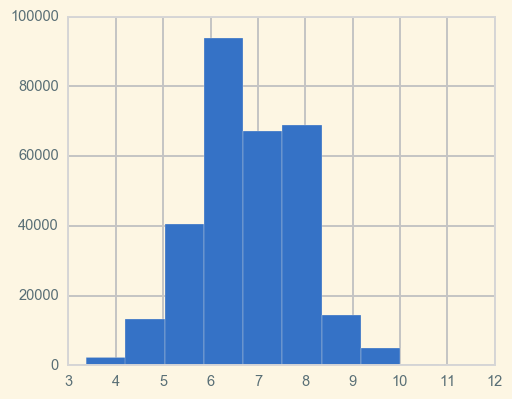

In [339]:
df=wd
plt.hist(df['wind'],weights=df['smartpower'])

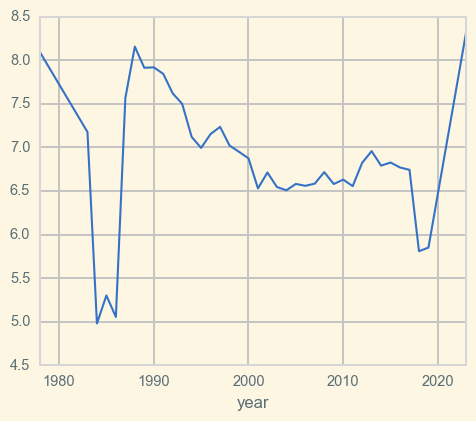

In [373]:
wd.loc['no'].groupby('year').mean()['wind'].plot()

In [408]:
def wavg(group):
    d = group['wind']
    w = group['power']
    return (d * w).sum() / w.sum()
def wavgl(group):
    d = group['wind']
    w = group['powerlog']
    return (d * w).sum() / w.sum()

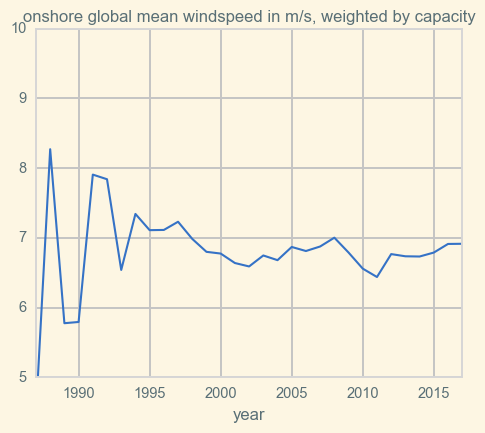

In [424]:
wd.loc['no'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
plt.ylim(5,10)
plt.title('onshore global mean windspeed in m/s, weighted by capacity')

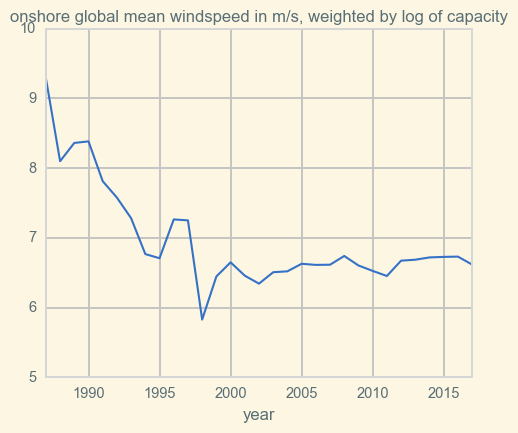

In [423]:
wd.loc['no'].groupby('year').apply(wavgl).plot()
plt.xlim(1987,2017)
plt.ylim(5,10)
plt.title('onshore global mean windspeed in m/s, weighted by log of capacity')

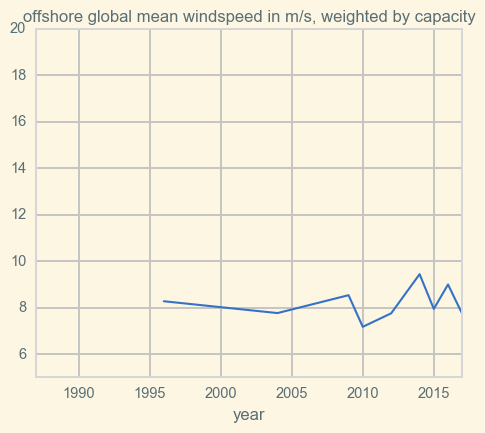

In [433]:
wd.loc['yes'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
plt.ylim(5,20)
plt.title('offshore global mean windspeed in m/s, weighted by capacity')

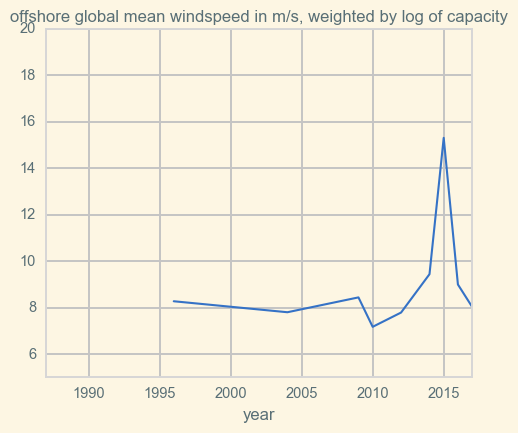

In [432]:
wd.loc['yes'].groupby('year').apply(wavgl).plot()
plt.xlim(1987,2017)
plt.ylim(5,20)
plt.title('offshore global mean windspeed in m/s, weighted by log of capacity')

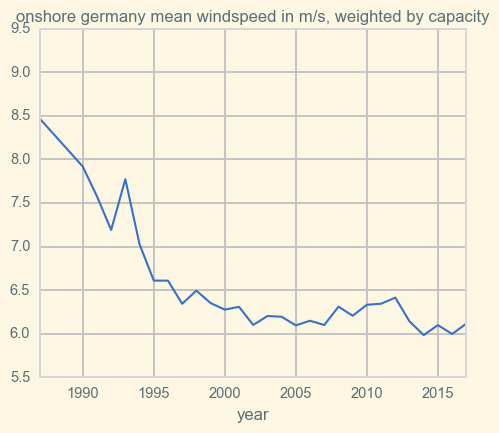

In [441]:
wd.loc['no'].set_index('ISO_CODE').loc['DE'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore germany mean windspeed in m/s, weighted by capacity')

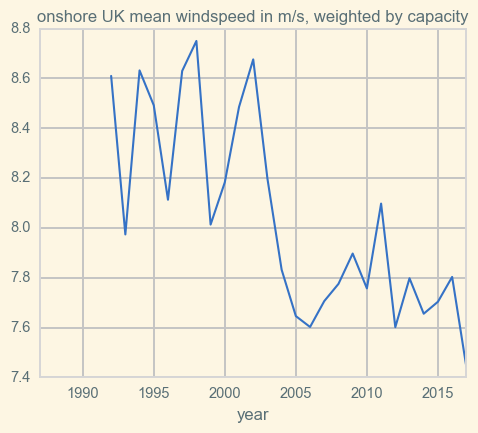

In [443]:
wd.loc['no'].set_index('ISO_CODE').loc['GB'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore UK mean windspeed in m/s, weighted by capacity')

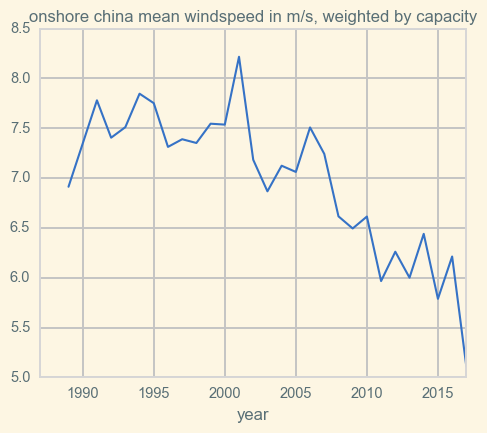

In [445]:
wd.loc['no'].set_index('ISO_CODE').loc['CN'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore china mean windspeed in m/s, weighted by capacity')

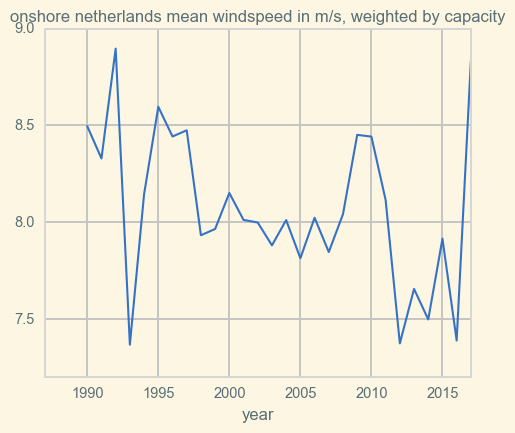

In [449]:
wd.loc['no'].set_index('ISO_CODE').loc['NL'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore netherlands mean windspeed in m/s, weighted by capacity')

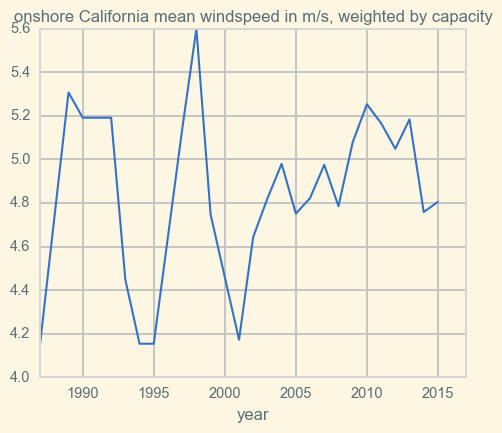

In [458]:
wd.loc['no'].set_index('Sub-national').loc['California'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore California mean windspeed in m/s, weighted by capacity')

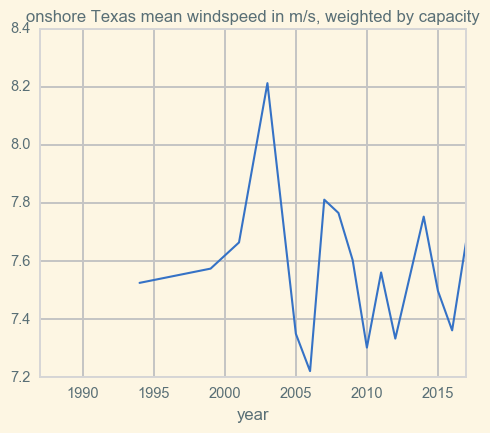

In [460]:
wd.loc['no'].set_index('Sub-national').loc['Texas'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore Texas mean windspeed in m/s, weighted by capacity')

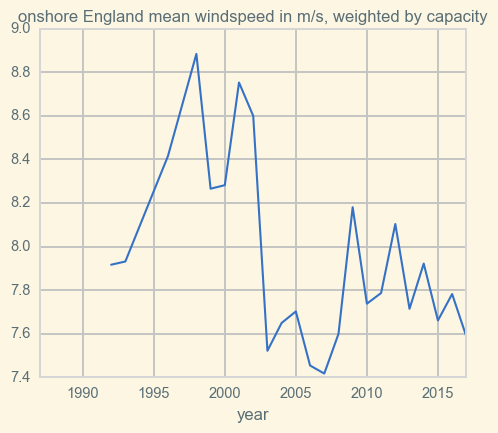

In [461]:
wd.loc['no'].set_index('Sub-national').loc['England'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore England mean windspeed in m/s, weighted by capacity')

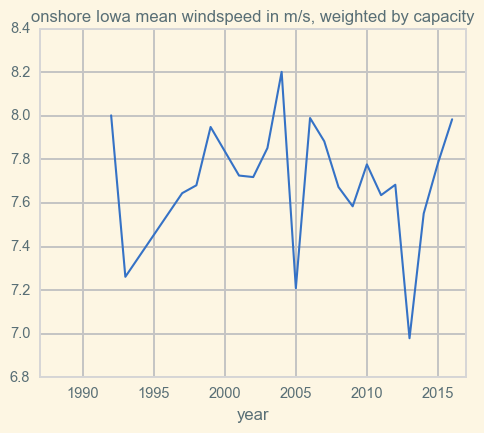

In [463]:
wd.loc['no'].set_index('Sub-national').loc['Iowa'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore Iowa mean windspeed in m/s, weighted by capacity')

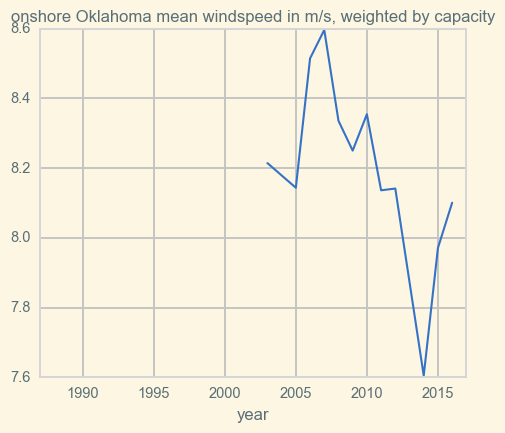

In [464]:
wd.loc['no'].set_index('Sub-national').loc['Oklahoma'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
#plt.ylim(5,10)
plt.title('onshore Oklahoma mean windspeed in m/s, weighted by capacity')

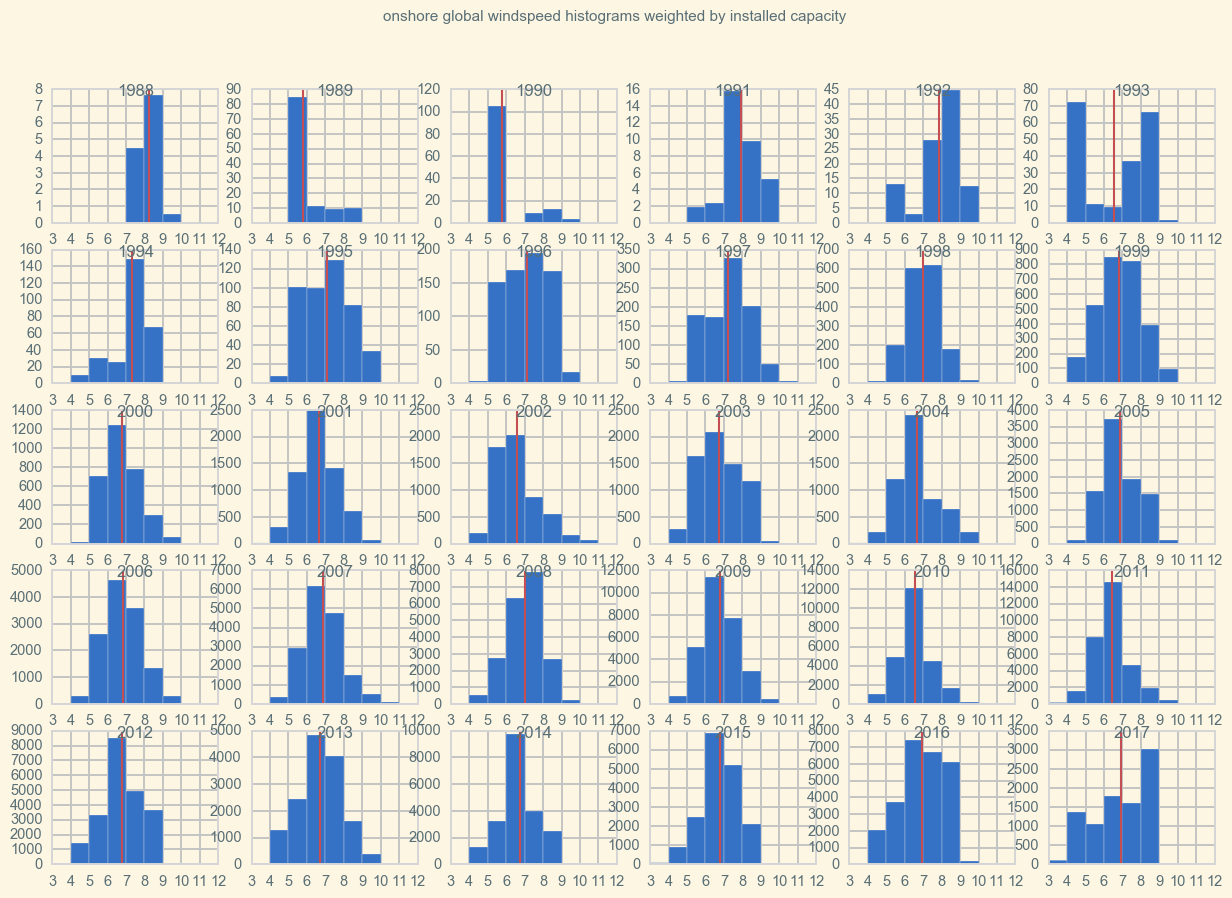

In [497]:
fig,ax=plt.subplots(5,6,figsize=(15,10))
for i in range(5):
    for j in range(6):
        year=i*6+j+1988
        df=wd.loc['no'].set_index('year').loc[year]
        ax[i][j].hist(df['wind'].values,weights=df['power'].values,bins=range(3,12))
        ax[i][j].set_xlim(3,12)
        ax[i][j].set_title(year,y=0.9)
        ax[i][j].axvline(np.average(df['wind'].values,weights=df['power'].values),color='r')
plt.suptitle('onshore global windspeed histograms weighted by installed capacity')

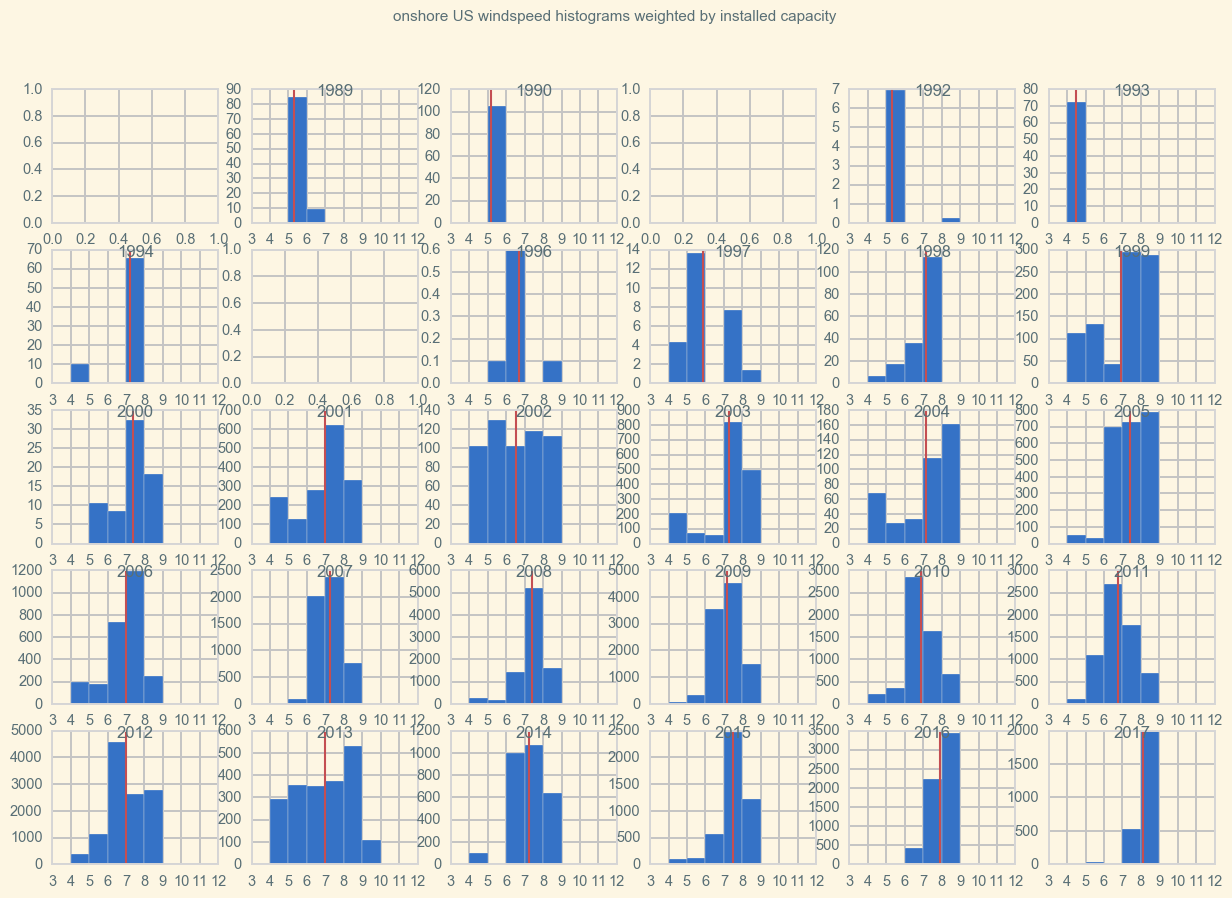

In [512]:
fig,ax=plt.subplots(5,6,figsize=(15,10))
for i in range(5):
    for j in range(6):
        year=i*6+j+1988
        try:
            df=wd.loc['no'].set_index('ISO_CODE').loc['US'].set_index('year').loc[year]
            ax[i][j].hist(df['wind'].values,weights=df['power'].values,bins=range(3,12))
            ax[i][j].set_xlim(3,12)
            ax[i][j].set_title(year,y=0.9)
            ax[i][j].axvline(np.average(df['wind'].values,weights=df['power'].values),color='r')
        except:pass
plt.suptitle('onshore US windspeed histograms weighted by installed capacity')

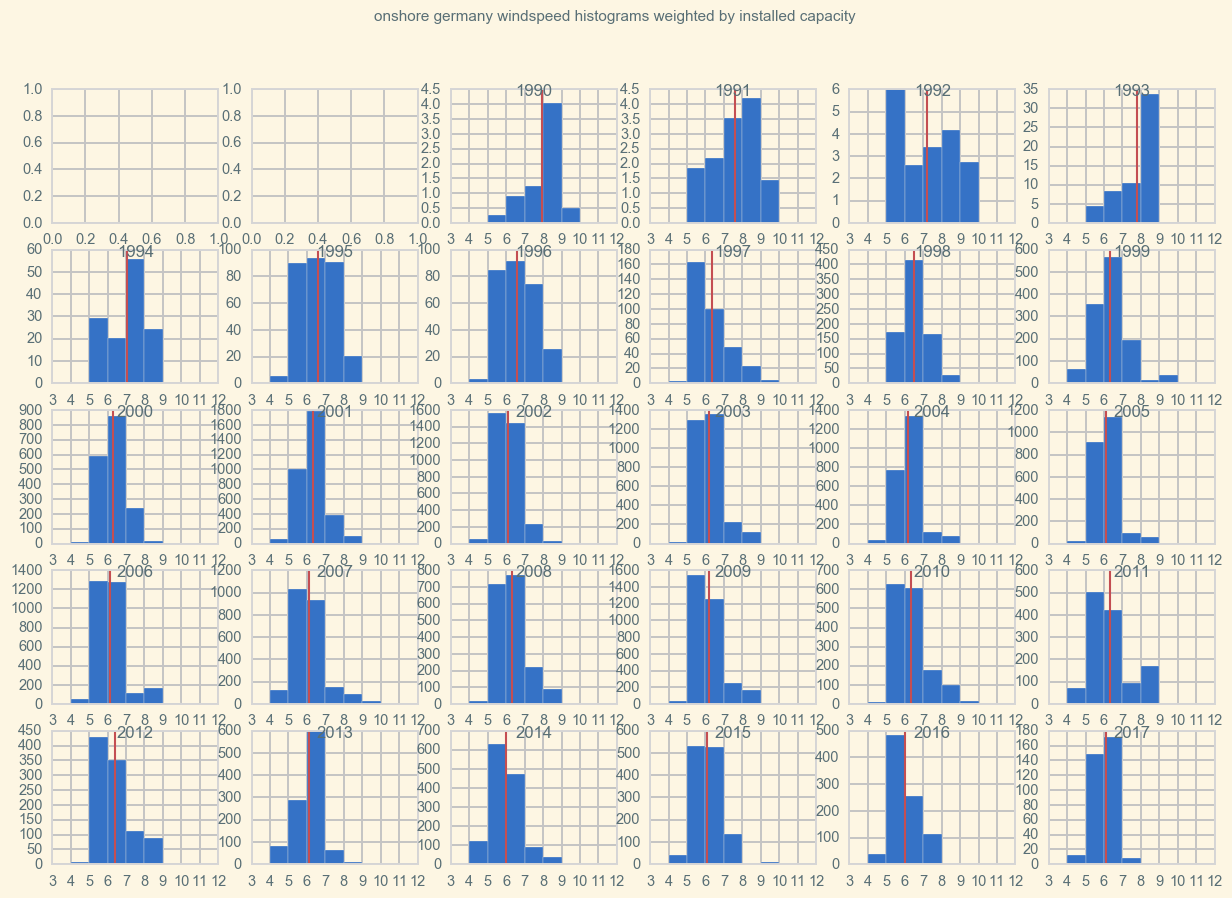

In [513]:
fig,ax=plt.subplots(5,6,figsize=(15,10))
for i in range(5):
    for j in range(6):
        year=i*6+j+1988
        try:
            df=wd.loc['no'].set_index('ISO_CODE').loc['DE'].set_index('year').loc[year]
            ax[i][j].hist(df['wind'].values,weights=df['power'].values,bins=range(3,12))
            ax[i][j].set_xlim(3,12)
            ax[i][j].set_title(year,y=0.9)
            ax[i][j].axvline(np.average(df['wind'].values,weights=df['power'].values),color='r')
        except:pass
plt.suptitle('onshore germany windspeed histograms weighted by installed capacity')

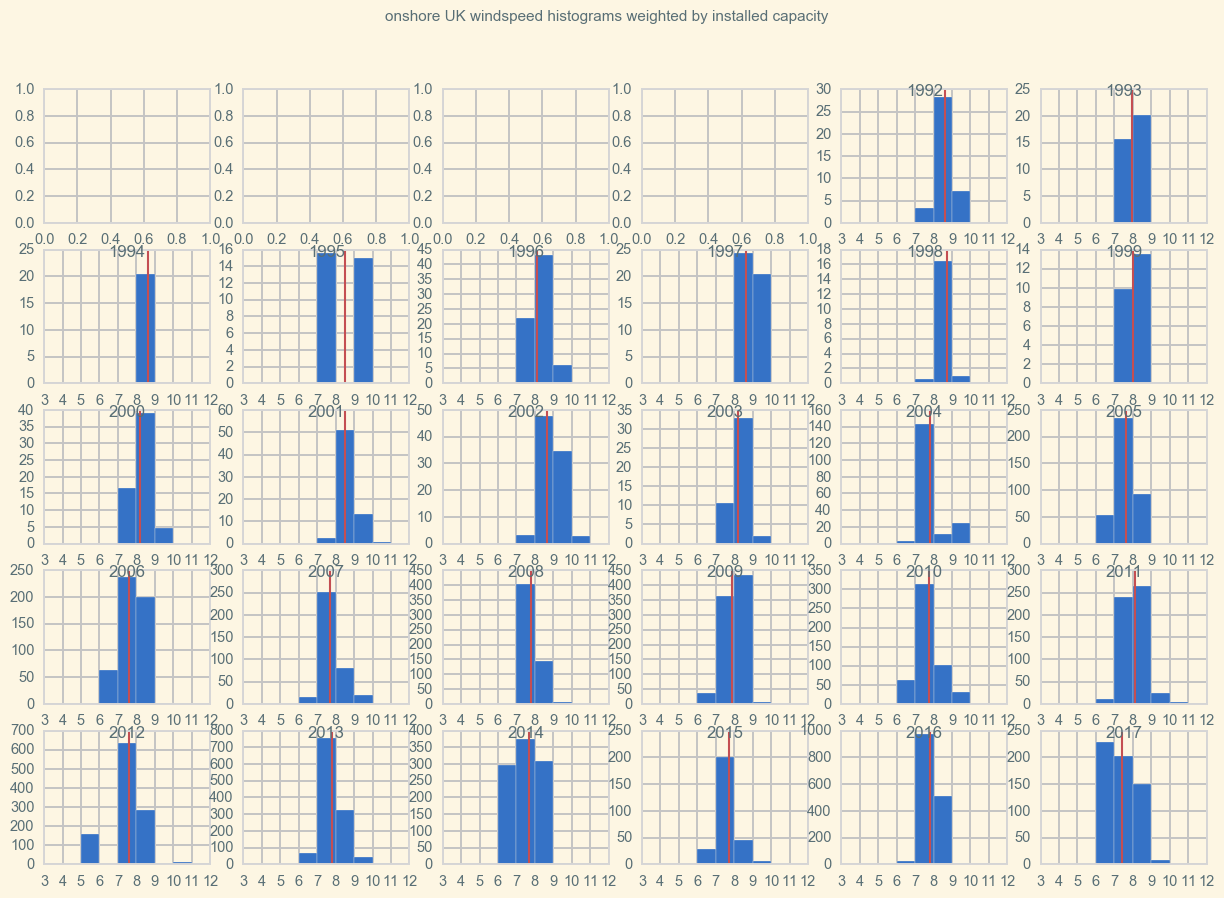

In [514]:
fig,ax=plt.subplots(5,6,figsize=(15,10))
for i in range(5):
    for j in range(6):
        year=i*6+j+1988
        try:
            df=wd.loc['no'].set_index('ISO_CODE').loc['GB'].set_index('year').loc[year]
            ax[i][j].hist(df['wind'].values,weights=df['power'].values,bins=range(3,12))
            ax[i][j].set_xlim(3,12)
            ax[i][j].set_title(year,y=0.9)
            ax[i][j].axvline(np.average(df['wind'].values,weights=df['power'].values),color='r')
        except:pass
plt.suptitle('onshore UK windspeed histograms weighted by installed capacity')

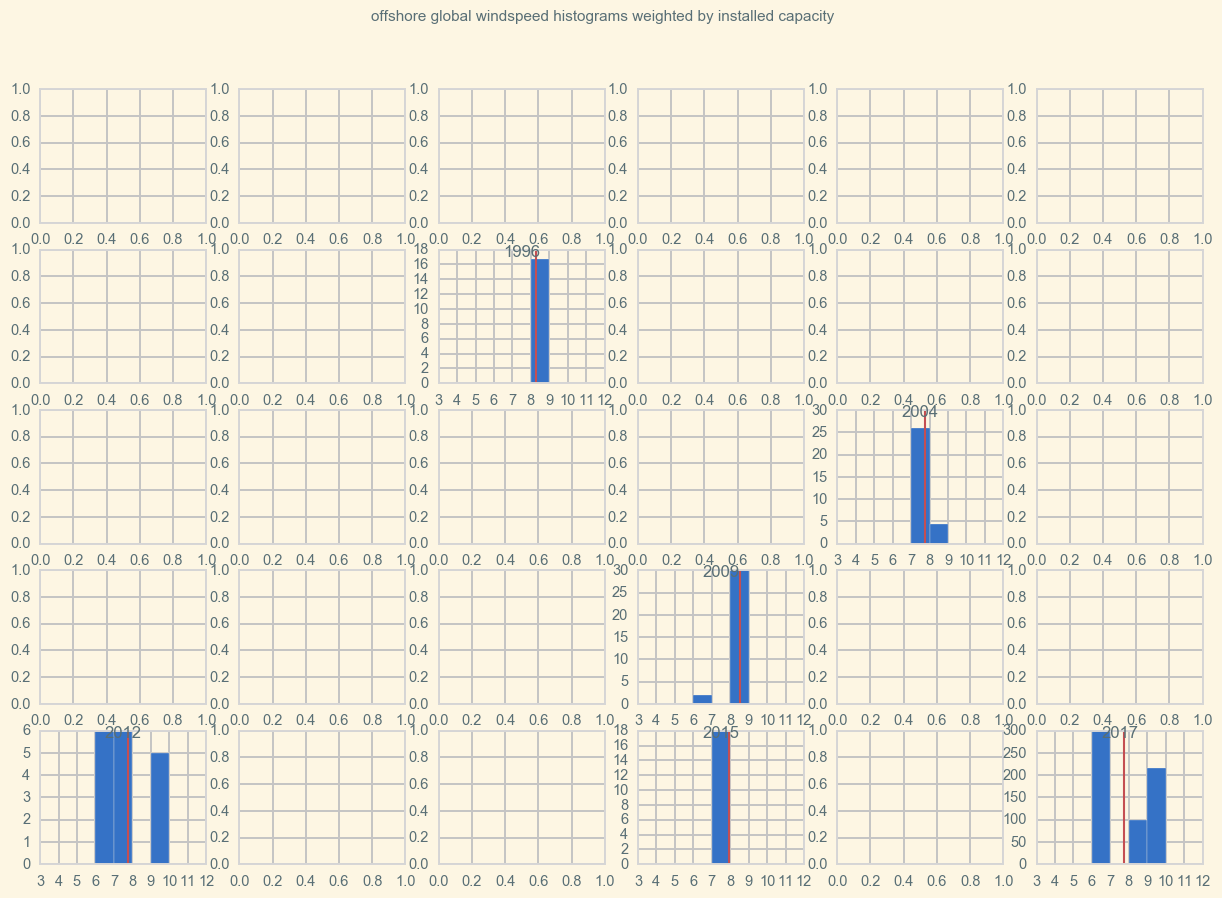

In [516]:
fig,ax=plt.subplots(5,6,figsize=(15,10))
for i in range(5):
    for j in range(6):
        year=i*6+j+1988
        try:
            df=wd.loc['yes'].set_index('year').loc[year]
            ax[i][j].hist(df['wind'].values,weights=df['power'].values,bins=range(3,12))
            ax[i][j].set_xlim(3,12)
            ax[i][j].set_title(year,y=0.9)
            ax[i][j].axvline(np.average(df['wind'].values,weights=df['power'].values),color='r')
        except:pass
plt.suptitle('offshore global windspeed histograms weighted by installed capacity')